In [1]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4

In [2]:
load_dotenv()
llm = ChatGroq(model="openai/gpt-oss-120b")

In [3]:
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]

memory = MemorySaver()

llm_with_tools = llm.bind_tools(tools = tools)

C:\Users\Yash pandey\AppData\Local\Temp\ipykernel_18756\2130009458.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


In [8]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return{
        "messages":[result],
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls)>0):
        return "tool_node"
    else:
        return END

async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""

    tool_calls = state["messages"][-1].tool_calls

    tool_messages = []
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name=="tavily_search_results_json":
            search_results = await search_tool.ainvoke(tool_args)

            tool_message = ToolMessage(
                content = str(search_results),
                tool_call_id = tool_id,
                name = tool_name
            )
            tool_messages.append(tool_message)
    return {"messages": tool_messages}

graph_builder = StateGraph(State)
graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

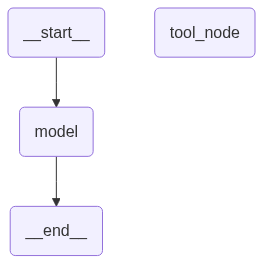

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [10]:
config = {
    "configurable":{
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages":[HumanMessage(content="How is the weather in bangalore?")],
    
}, config=config)

response

{'messages': [HumanMessage(content='Hi how are you doing?', additional_kwargs={}, response_metadata={}, id='08278e7c-3894-4101-8b9e-fd9d73db970d'),
  AIMessage(content='Hello! I’m doing great, thank you for asking. How can I help you today?', additional_kwargs={'reasoning_content': 'We need to respond. The user asks: "Hi how are you doing?" It\'s a casual greeting. We can respond politely. No need to use tools.'}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 160, 'total_tokens': 221, 'completion_time': 0.127011762, 'prompt_time': 0.010722605, 'queue_time': 0.061695875, 'total_time': 0.137734367}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d9805f2c-4e5a-4dc0-b53f-b7610a6b5d93-0', usage_metadata={'input_tokens': 160, 'output_tokens': 61, 'total_tokens': 221}),
  HumanMessage(content='How is the weather in bangalore?', additional_kwargs={}, res

In [15]:
config = {
    "configurable":{
        "thread_id": 6
    }
}
async for event in graph.astream_events({
    "messages":[HumanMessage(content="Give essay of 1000 words on climate change")],
    
}, config=config, version="v2"):
    if event["event"]=="on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

**Climate Change: A 1,000‑Word Overview**

---

### Introduction  

Climate change is no longer a distant scientific hypothesis; it is an unfolding reality that reshapes ecosystems, economies, and societies across the globe. At its core, climate change refers to long‑term alterations in temperature, precipitation, wind patterns, and other aspects of the Earth’s climate system, driven primarily by human activities that increase concentrations of greenhouse gases (GHGs) in the atmosphere. While natural factors such as volcanic eruptions and solar variability have always influenced climate, the unprecedented rate of warming observed since the mid‑20th century is overwhelmingly linked to the combustion of fossil fuels, deforestation, industrial processes, and modern agricultural practices. This essay examines the scientific basis of climate change, its observable impacts, the social and economic consequences, mitigation and adaptation strategies, and the role of international cooperation i